**Engy-4390** Nuclear Systems Design and Analysis, UMass Lowell, Chem. Eng. Nuclear Program Fall 2024

# Uranium Mill Network Dynamics Simulation
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

## Coupling Leaching, Decantation-Filtration, and Solvex Modules
In construction...<br>
[Project Repository on `GitHub`](https://github.com/dpploy/engy-4390/tree/main/projects/2024/u-mill)

---
## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
* [References](#refs)
---

## [Objectives](#toc)<a id="obj"></a>

- Test the implementation of coupled modules in Cortix. 
- Present an executable environment for learning how to use the Cortix modules developed for a simplified Whit Mesa Milling flowsheet.

In [1]:
"""Setup a White Mesa plant"""

from cortix import Cortix
from cortix import Network
from cortix import Units as unit
white_mesa = Cortix(use_mpi=False, splash=True)   # system top level, establish system
wm_net = white_mesa.network = Network()           # creating system network

# help(white_mesa.network)

[20180] 2024-12-11 17:49:14,223 - cortix - INFO - Created Cortix object 
_____________________________________________________________________________
                             L A U N C H I N G                               
_____________________________________________________________________________
      ...                                        s       .     (TAAG Fraktur)
   xH88"`~ .x8X                                 :8      @88>
 :8888   .f"8888Hf        u.      .u    .      .88      %8P      uL   ..
:8888>  X8L  ^""`   ...ue888b   .d88B :@8c    :888ooo    .     .@88b  @88R
X8888  X888h        888R Y888r ="8888f8888r -*8888888  .@88u  ""Y888k/"*P
88888  !88888.      888R I888>   4888>"88"    8888    888E`    Y888L
88888   %88888      888R I888>   4888> "      8888      888E      8888
88888 `> `8888>     888R I888>   4888>        8888      888E      `888N
`8888L %  ?888   ! u8888cJ888   .d888L .+    .8888Lu=   888E   .u./"888&
 `8888  `-*""   /   "*888*P"    ^"8888*"     ^%

In [2]:
'''Setup Leaching'''
from src.leaching import Leaching # this will give access to the python module docstring
leaching = Leaching()
wm_net.module(leaching) 

In [3]:
'''Setup Decantation-Filtration'''
from src.decantation_filtration import DecantationFiltration# this will give access to the python module docstring
decant_filt = DecantationFiltration()
wm_net.module(decant_filt) 

In [4]:
'''Setup Solvent Extraction'''
from src.solvex import Solvex
solvex = Solvex()
wm_net.module(solvex)

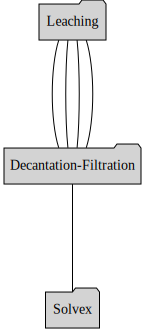

In [5]:
'''Setup Network'''
wm_net.connect([leaching, 'pre-leach-product'], [decant_filt, 'std-feed'])
wm_net.connect([decant_filt, 'ccd-overflow'], [leaching, 'pre-leach-feed'])
wm_net.connect([leaching, 'acid-leach-product'], [decant_filt, 'ccd-feed'])
wm_net.connect([decant_filt, 'std-underflow'], [leaching, 'acid-leach-feed'])
wm_net.connect([decant_filt, 'filtrate'], [solvex, 'stripping-feed'])

wm_net.draw(engine='dot', node_shape='folder', size='600,1200')

In [6]:
'''Initialize run'''
end_time = 30*unit.day
time_step = 12.0*unit.hour
show_time = (True, unit.hour)

for m in wm_net.modules:
    m.end_time = end_time
    m.time_step = time_step
    m.show_time = show_time

In [ ]:
'''Run White Mesa and shutdown'''   
white_mesa.run()
white_mesa.close()

[20180] 2024-12-11 17:49:14,625 - cortix - INFO - Launching Module <src.leaching.Leaching object at 0x000002EC32CF9910>
[20180] 2024-12-11 17:49:14,710 - cortix - INFO - Launching Module <src.decantation_filtration.DecantationFiltration object at 0x000002EC3282AC90>
[20180] 2024-12-11 17:49:14,782 - cortix - INFO - Launching Module <src.solvex.Solvex object at 0x000002EC3344F190>


In [ ]:
'''Recover modules data'''
leaching = wm_net.modules[0]
decant_filt = wm_net.modules[1]

In [ ]:
'''Leaching data'''
leaching.preleach_phase.plot(['liquid-volume','mass-flowrate','mass-density'],show=True,figsize=[14,8])
leaching.acidleach_phase.plot(['liquid-volume','mass-flowrate','mass-density'],show=True,figsize=[14,8])

In [ ]:
'''Decantation/Filtration and plot'''
import matplotlib.pyplot as plt
(quant, time_unit) = decant_filt.std_state_phase.get_quantity_history('liquid-volume')
quant.plot(x_scaling=1/unit.day, x_label='Time [d]',y_label=quant.latex_name+' ['+quant.unit+']')
plt.grid()

In [ ]:
(quant, time_unit) = decant_filt.ccd_state_phase.get_quantity_history('liquid-volume')
quant.plot(x_scaling=1/unit.day, x_label='Time [d]',y_label=quant.latex_name+' ['+quant.unit+']')
plt.grid()

In [ ]:
(quant, time_unit) = decant_filt.ccd_overflow_phase.get_quantity_history('mass-flowrate')
quant.plot(x_scaling=1/unit.day, y_scaling=unit.minute, x_label='Time [d]', y_label=quant.latex_name + ' [kg/min]')
plt.grid()

In [ ]:
(quant, time_unit) = decant_filt.ccd_underflow_phase.get_quantity_history('mass-flowrate')
quant.plot(x_scaling=1/unit.day, y_scaling=unit.minute, x_label='Time [d]', y_label=quant.latex_name + ' [kg/min]')
plt.grid()

## [References](#toc)<a id="refs"></a>